<a href="https://colab.research.google.com/github/tavishcode/fyp/blob/master/autoencoder_with_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import datetime 
import math
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Activation, GRU, Dense, LSTM, RepeatVector
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, normalize
# import holidays
from collections import OrderedDict, defaultdict
# from google.colab import drive
import time
# drive.mount('/content/drive')
plt.rcParams['figure.figsize'] = [18, 5]

In [33]:
# If local
train = np.load('data/train_set.npy')
test = np.load('data/test_set.npy')
test.shape

(27222, 100, 9)

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
train = np.load('drive/My Drive/train_set.npy')
test = np.load('drive/My Drive/test_set.npy')
test.shape

## AutoEncoder + GRU prediction

In [0]:
# !pip install fbprophet
# !pip install sklearn

In [141]:
req_sum = np.zeros(train.shape[1])
pred_req_sum = np.zeros(train.shape[1])
decoded_data = np.zeros(train.shape)
preds = np.zeros((train.shape[0], train.shape[1]))


window = 1

### Train Simple Autoencoder

  - 100 days
  - 27222 features
  - 50 epochs

In [157]:
def get_simple_autoencoder(num_features,encoding_dim,window):
  compression_factor = float(num_features) / encoding_dim
  print("Compression factor: %s" % compression_factor)

  autoencoder = Sequential()
  autoencoder.add(Dense(encoding_dim, input_shape=(window,num_features,), activation='relu'))
  autoencoder.add(Dense(num_features, activation='relu'))
#   autoencoder.summary()

  input_encoder = Input(shape=(window,num_features))
  encoder_layer = autoencoder.layers[0]
  encoder = Model(input_encoder, encoder_layer(input_encoder))

  autoencoder.compile(optimizer='adam', loss='mae')
  return autoencoder, encoder

In [ ]:
encoding_dims = [5,4,3,2]
num_days = 100
for encoding_dim in encoding_dims:
  autoencoder, encoder = get_simple_autoencoder(num_features,encoding_dim,window)
  ae_error = []
  for i in range(window, num_days if num_days<train.shape[1] else train.shape[1]):
    x = np.copy(train[:, i - window : i, 1:]).reshape(-1, window, num_features)
    start = time.clock()
    history = autoencoder.fit(x, x, epochs=20, verbose=0)
    ae_error += history.history['loss']
  autoencoder.save('autoencoder-'+str(encoding_dim))
  encoder.save('encoder-'+str(encoding_dim))
  plt.plot(ae_error,label='dim '+ str(encoding_dim))
plt.legend()


Compression factor: 1.6


### Train GRU model

In [ ]:
def get_GRU(input_dim,hidden_units):
    model = Sequential()
    model.add(GRU(hidden_units, input_shape=(window, input_dim)))
    model.add(Dense(1))
    model.add(Activation('relu'))
    model.compile(optimizer='adam', loss='mae')
#     model.summary()
    return model

In [166]:
encoder2 = load_model('encoder-2')
# encoder3 = load_model('encoder-3')
# encoder4 = load_model('encoder-4')
# encoder5 = load_model('encoder-5')
# encoders = [encoder2,encoder3,encoder3,encoder4,encoder4,encoder5]
encoders = [encoder2]
input_dims = [4]
hidden_units = [64]

In [ ]:
for r,encoder in enumerate(encoders):
    print(encoder.layers[1].output_shape)
    encoder.summary()

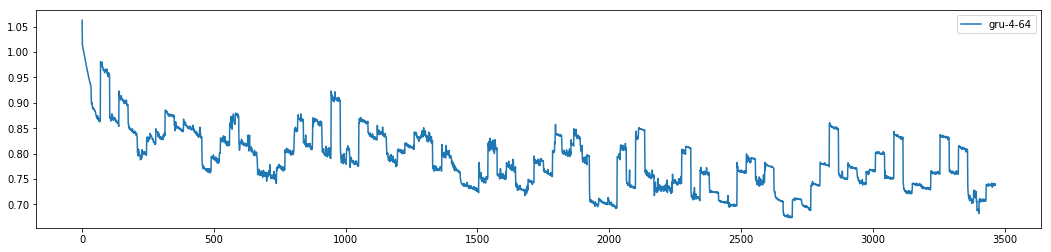

In [167]:
num_days = 100
alpha = 0.1
for r,encoder in enumerate(encoders):
#     print(encoder.layers[0].output_shape)
    input_dim = input_dims[r]
    grumodel = get_GRU(input_dim,hidden_units[r])
    gru_error = []
    exp_avg = 0
    for i in range(window, num_days if num_days<train.shape[1] else train.shape[1]): # i is days
        x_to_encode = np.copy(train[:, i - window : i, 1:]).reshape(-1, window, num_features)
#         print(x.shape)
        start = time.clock()
        reqs = np.copy(train[:, i - window : i, 0]).reshape(-1,window,1)
        encoded_x = encoder.predict(x_to_encode,verbose=0).reshape(train.shape[0],1,-1) #3/4/5
        if exp_avg is None:
            exp_avg = train[:, i - window : i, 0].reshape(-1,1,1)
        else:
            exp_avg = alpha*train[:, i - window : i, 0].reshape(-1,1,1) + (1-alpha)*exp_avg # 1
        y = np.copy(train[:,i,0]).reshape(-1, 1)
#         print(reqs.shape,encoded_x.shape,exp_avg.shape)
        x = np.concatenate((reqs,encoded_x,exp_avg.reshape(-1,1,1)), axis=2).reshape(-1, 1, input_dim)
    #     print(x.shape)
        history = grumodel.fit(x,y,epochs=35, verbose=0)
        gru_error += history.history['loss']
    grumodel.save('gru-'+str(input_dim)+'-'+str(hidden_units[r]))
    plt.plot(gru_error,label='gru-'+ str(input_dim)+'-'+str(hidden_units[r]))
plt.legend()
plt.show()

In [163]:
encoder2 = load_model('encoder-2')
encoder3 = load_model('encoder-3')
encoder4 = load_model('encoder-4')
encoder5 = load_model('encoder-5')
gru_4_256 = load_model('gru-4-256')
gru_5_64 = load_model('gru-5-64')
gru_5_128 = load_model('gru-5-128')
gru_6_64 = load_model('gru-6-64')
gru_6_128 = load_model('gru-6-128')
# gru_7_64 = load_model('gru-7-64')


In [169]:
gru_4_64 = load_model('gru-4-64')

In [168]:
mr_gru = [(encoder2,gru_4_64),(encoder2,gru_4_256),(encoder3,gru_5_64),(encoder3,gru_5_128),(encoder4,gru_6_64),(encoder4,gru_6_128)]
cache_size = int(0.01 * test.shape[0])
num_days = 100
for encoder,grumodel in mr_gru:
    hit_ratios = []
    exp_avg = 0
    for i in range(window, num_days if num_days<test.shape[1] else test.shape[1]): # for each timestep
#         if i%10 == 0:
#             print(i)
        preds = [] # predicted popularities for all objects at time i
        true_labels = [] # actual popularities for all objects at time i
        reqs = np.copy(test[:, i - window : i, 0]).reshape(-1,window,1)
        x_to_encode = np.copy(train[:, i - window : i, 1:]).reshape(-1, window, num_features)
        encoded_x = encoder.predict(x_to_encode,verbose=0).reshape(test.shape[0],1,-1) #3
    #     y = np.copy(train[:,i,0]).reshape(-1, 1)
        if exp_avg is None:
            exp_avg = test[:, i - window : i, 0].reshape(-1,1,1)
        else:
            exp_avg = alpha*test[:, i - window : i, 0].reshape(-1,1,1) + (1-alpha)*exp_avg # 1
        x = np.concatenate((reqs,encoded_x,exp_avg.reshape(-1,1,1)), axis=2).reshape(test.shape[0], 1, -1)
        pred = grumodel.predict(x).ravel()
    #     print("pred", pred)
        cached_items = np.argsort(pred)[::-1][:cache_size]
    #     print("cached items",cached_items)
#         preds.append(pred)
        total = np.sum(test[:,i,0])
        assert(total<500000)
        temp_hit_ratio = 0
        for item in cached_items:
            temp_hit_ratio += test[item, i, 0]/total
        hit_ratios.append(temp_hit_ratio)
    print(sum(hit_ratios)/len(hit_ratios))
    plt.plot(hit_ratios)
plt.legend(['gru_4_64','gru_4_256','gru_5_64','gru_5_128','gru_6_64','gru_6_128'])

NameError: name 'gru_4_64' is not defined

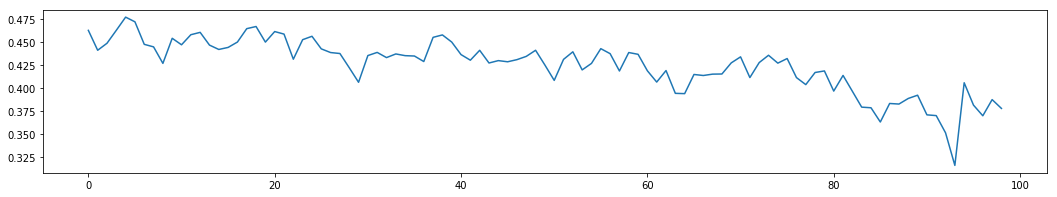

In [100]:
plt.rcParams['figure.figsize'] = [18, 3]
plt.plot(hit_ratios)

### Train LSTM autoencoder
  
  - 100 days
  - 27222 features
  - 50 epochs

In [0]:
inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

def get_lstm_autoencoder(num_features,encoding_dim,window):
  compression_factor = float(num_features) / encoding_dim
  print("Compression factor: %s" % compression_factor)
  inputs = Input(shape=(window, num_features))
  encoded = LSTM(encoding_dim)(inputs)

  decoded = RepeatVector(window)(encoded)
  decoded = LSTM(num_features, return_sequences=True)(decoded)

  sequence_autoencoder = Model(inputs, decoded)
  sequence_autoencoder.compile(optimizer='adam', loss='mse')
  encoder = Model(inputs, encoded)
  encoder.compile(optimizer='adam', loss='mse')
  return sequence_autoencoder, encoder

In [0]:
encoding_dims = [1,3,6,7]
num_days = 10
for encoding_dim in encoding_dims:
  autoencoder, encoder = get_lstm_autoencoder(num_features,encoding_dim,window)
  ae_error = []
  for i in range(window, num_days if num_days<train.shape[1] else train.shape[1]):
    x = np.copy(train[:, i - window : i, :]).reshape(-1, window, train.shape[2])
    print(x.shape)
  #   p = autoencoder.predict(x)
    start = time.clock()
    autoencoder.fit(x, x, epochs=50, verbose=0)
    print(time.clock() - start)
    print(str(i)+'/'+str(train.shape[1]))
    error = autoencoder.evaluate(x,x,verbose=0)
    ae_error.append(error)
  print(autoencoder.evaluate(x,x))
  autoencoder.save('drive/My Drive/lstm-autoencoder-'+str(encoding_dim))
  encoder.save('drive/My Drive/lstm-encoder-'+str(encoding_dim))
  plt.plot(ae_error)